# Data Profiling of 2024 and 2025 saved JPGs from Bird Feeder

This notebook profiles the images obtained from the Madison, WI bird feeder in 2024 though Jan 2025. The notebook will look at the distribution species observed, profile the likely false positives (low total count), visually inspect these errors to determine the cause, and review the quality of the images.  
  
Additional work will be performed to profile the train and test data set to compare species distribution and the quality and size of these images as they compare to what the feeder actually produced.  

In [17]:
# CV2 doesn't install well on the rasp pi so we will try and limit the usage of that library across the analysis so as not to introduce techniques that cannot be repeated on the feeder.   
# To the end, this notebook shares a code base with the feeder using the gcs.py and image_proc.py python files from the feeder project itself.  
try:
    import cv2
except:
    !pip install opencv-contrib-python
    import cv2

In [18]:
import pandas as pd
import gcs_inventory as gcsi
import matplotlib.pyplot as plt
import gcs
from io import BytesIO
from PIL import Image
import numpy as np
import image_proc
import time
import datetime

In [2]:
# set up gcs storage for future reference throughout
web_storage = gcs.Storage(bucket_name='archive_jpg_from_birdclassifier')

# read the list of files created with gcs_inventory locally and uploaded via git
# saves some $$ avoiding a full list from gcs repeatedly
df_file_name = 'raw_archive-jpg-list.csv'
try: 
    df_raw = pd.read_csv(df_file_name)  # reload existing file if it exists, delete it if you want to recreate it
    print(f'Loading existing file {df_file_name}')
except:
    df_raw = gcsi.get_archived_jpg_images(df_file_name)  # .01 per 1000 operations so about $0.80 per run, create from scratch
    print(f'Reading images from GCS....')

# clean the data and remove files that have a bad name, only numbers for species name
df_raw = df_raw[df_raw['Name'].str.contains(r'[a-zA-Z]', na=False)]  # na=False handles NaN values
    
# structure raw data
df_raw['DateTime'] = pd.to_datetime(df_raw['DateTime'], errors='raise')
df_raw.to_csv(df_file_name, index=False)
print(f'Saved jpg list as {df_file_name}....')  # this save my be redundant if the file was loaded from disk vs. recreated from the gcs listing


Loading existing file raw_archive-jpg-list.csv
Saved jpg list as raw_archive-jpg-list.csv....


In [3]:
# profile df
print(f'df shape {df_raw.shape}')
print(df_raw.columns)
# print(df_raw.head(1))

df shape (84017, 8)
Index(['Number', 'Name', 'Year', 'Month', 'Day', 'Hour', 'DateTime',
       'Image Name'],
      dtype='object')


In [4]:
### helper functions  ###

# open cv does not install well on rasp pi, adding focal quality function here instead of image_proc
# this technique would need to be manually created in the image_proc lib for the pi
def focal_quality(img: Image.Image) -> float:
    laplacain_operator = cv2.Laplacian(np.array(image_proc.grayscale(img)), cv2.CV_64F)
    return laplacain_operator.var()

# filter by year function
def filter_by_year(df_raw, year: int): 
    print(f'Limiting list to {year} only....')
    df = df_raw[df_raw['DateTime'].dt.year == year].copy() # .copy() avoids warnings about setting values on slice
    print('')
    print(f'Starting date: {df["DateTime"].min()}')
    print(f'Ending date: {df["DateTime"].max()}')
    print(f'Number of Images: \t{df.shape[0]}\n')
    return df


In [5]:
# profile species observed in year 2024
df_2024 = filter_by_year(df_raw=df_raw, year=2024) 
name_counts_2024 = df_2024['Name'].value_counts()    


Limiting list to 2024 only....

Starting date: 2024-01-01 08:35:04
Ending date: 2024-12-31 15:18:02
Number of Images: 	74849



### Initial Image Review of 2024 Feeder Species and Images
After some experimentation it looks like occurrences less than 150 for the total year of 2024 may be good candidates to consider as false positives.  That analysis produces 17 species that frequent the feeder. 
 

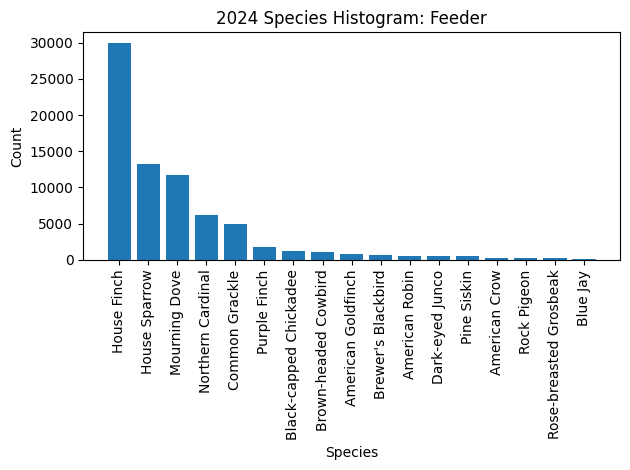

In [6]:
# print(f'Initial List of Species and Occurrences in 2024: \n{name_counts_2024[name_counts_2024 > 150]}')
# plot histograms for 2024 name counts exlcuing false positives <= 150
filtered_data = name_counts_2024[name_counts_2024 > 150]
plt.bar(filtered_data.index, filtered_data.values) 
plt.xticks(rotation='vertical')
plt.xlabel('Species')
plt.ylabel('Count')
plt.title('2024 Species Histogram: Feeder')
plt.tight_layout()
plt.show()


#### False Positive Review
The notebook grabs the first example image of the false positives to  allow a visual inspection.  The false positive images tend to be  over exposed, under exposed, blurry, or camera lens obstructed. After this visual inpection of 2024 and 2025 images, it turns out that there are three more species that in fact do visit the feeder.
Additional species from 2024 false positive analysis: Red-Bellied Woodpecker, Downy Woodpecker, White-Breasted Nuthatch  
Additional species from 2025 false positive analysis: Tree Sparrow
  
An analysis of the frequency relative to the number of attempted classifications would be useful to help pinpoint frequency and the ulitmate cause of the poor images.  



In [7]:
print(f'Possible False Positives: \n{name_counts_2024[name_counts_2024 <= 150]}')
print('')

Possible False Positives: 
Name
White-crowned Sparrow        123
Common GroundDove             99
White-throated Sparrow        88
Chipping Sparrow              80
Cedar Waxwing                 44
Indigo Bunting                36
Harris's Sparrow              35
Lark Sparrow                  29
Song Sparrow                  27
Black Phoebe                  19
Evening Grosbeak              15
Field Sparrow                 14
Vesper Sparrow                12
Chestnut-backed Chickadee     11
American Tree Sparrow         11
Lincoln's Sparrow              8
Snow Bunting                   5
Red-bellied Woodpecker         5
Carolina Wren                  4
White-breasted Nuthatch        4
Bewick's Wren                  3
California Towhee              3
Grasshopper Sparrow            2
Plain Chachalaca               2
Gray-headed Junco              2
Eurasian CollaredDove          2
Cinnamon Teal                  2
Northern Jacana                1
Barred Owl                     1
Lesser Gold

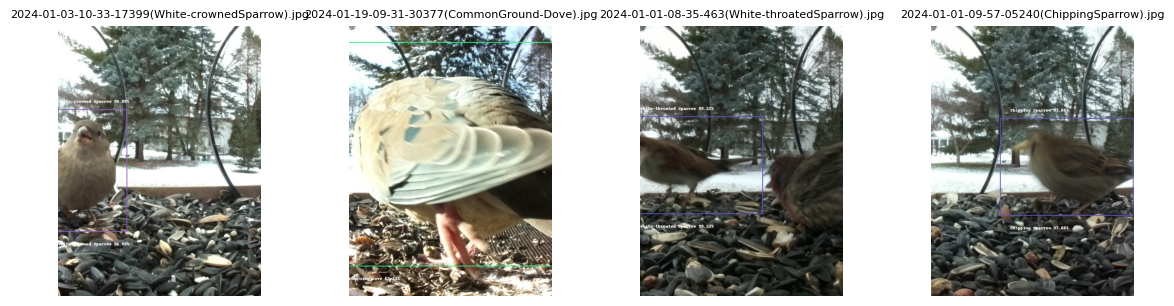

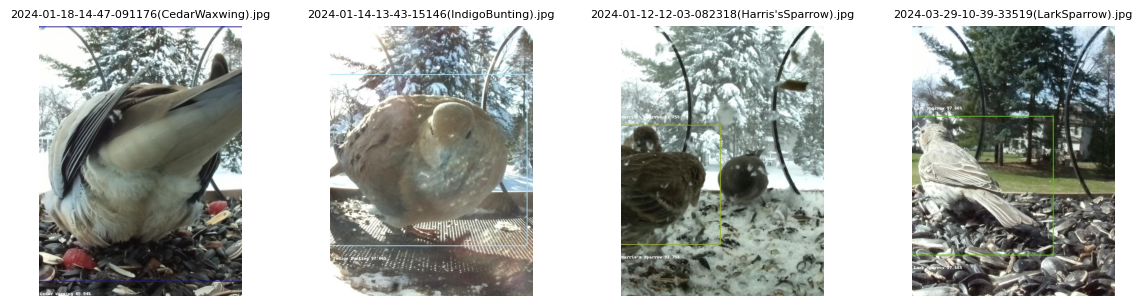

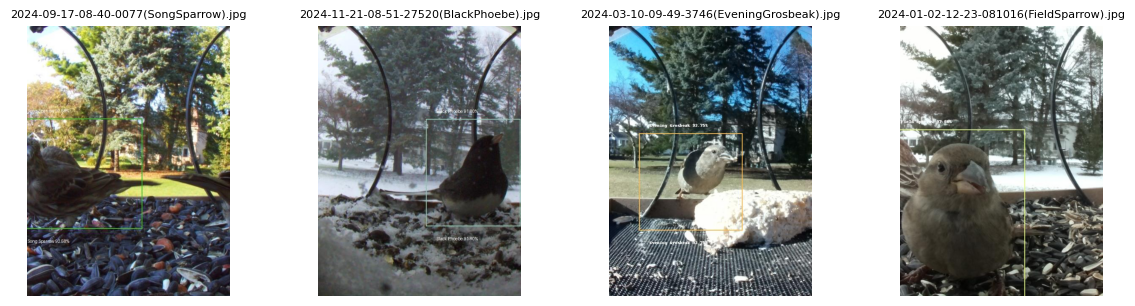

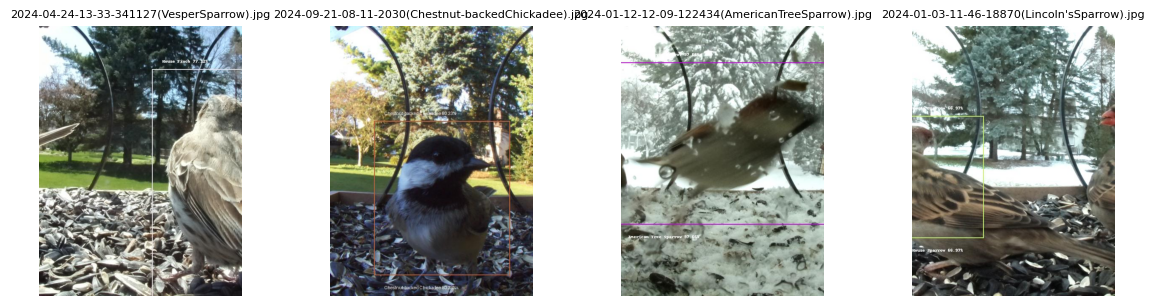

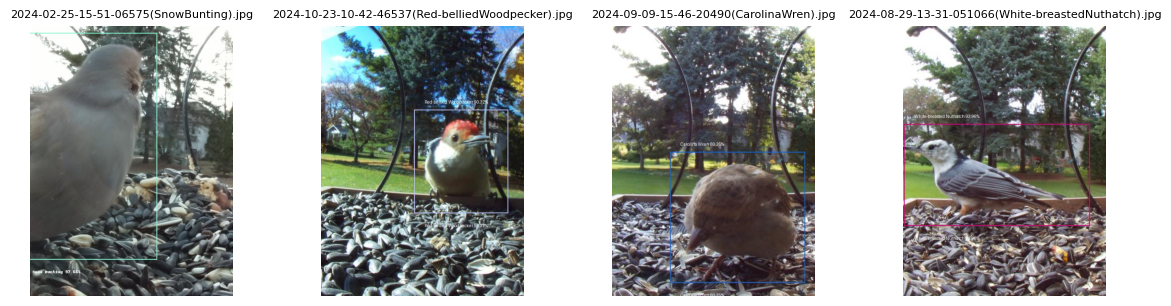

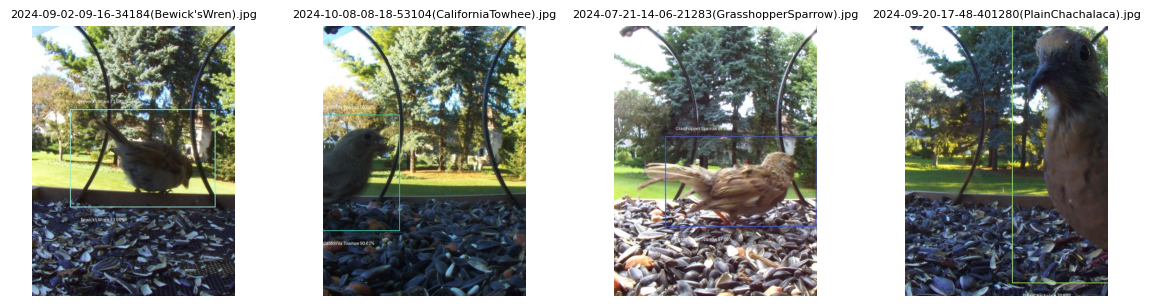

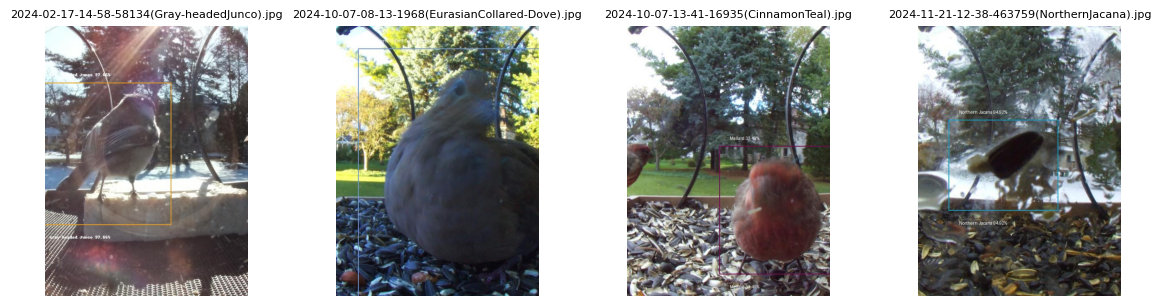

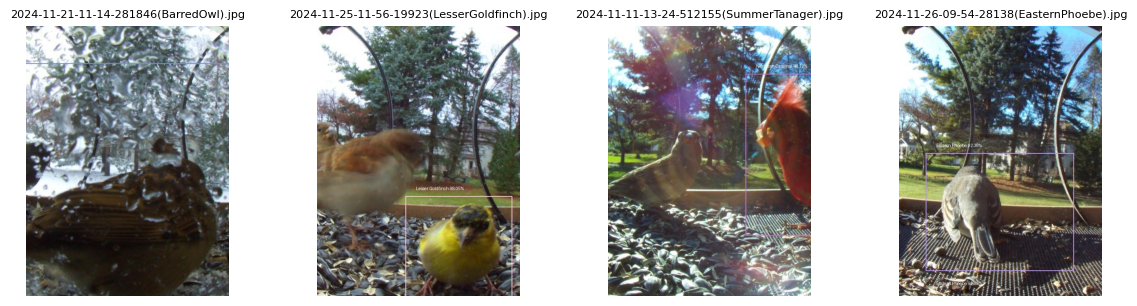

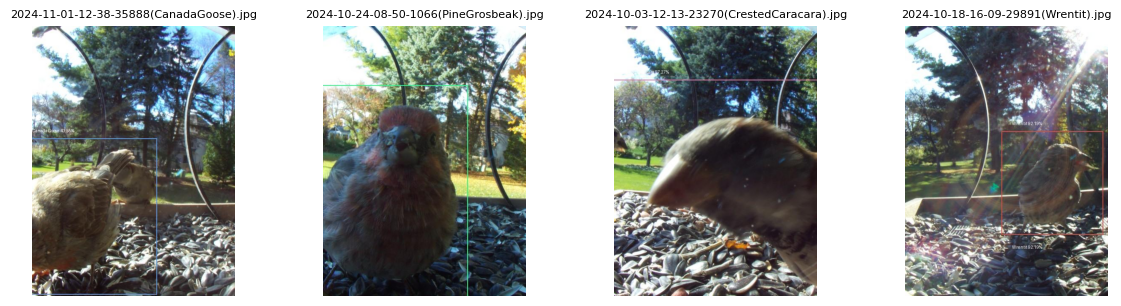

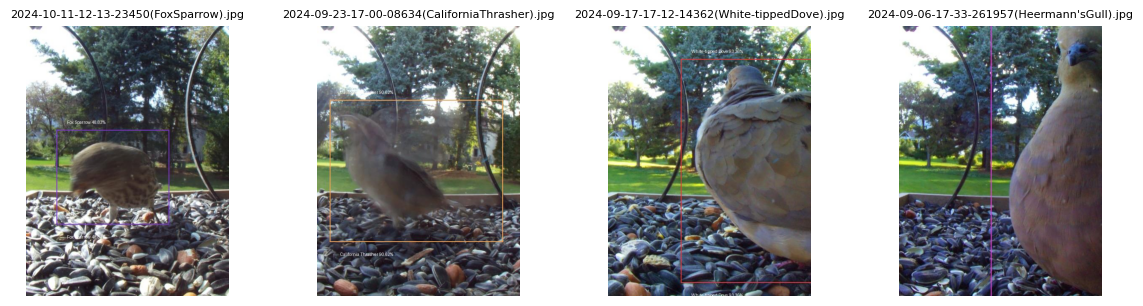

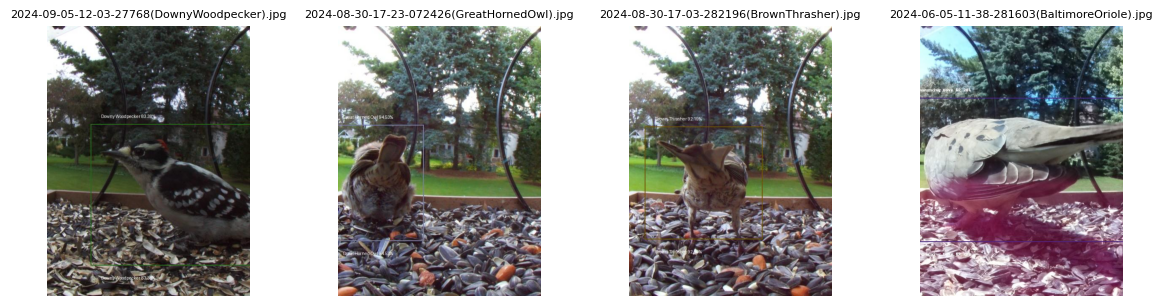

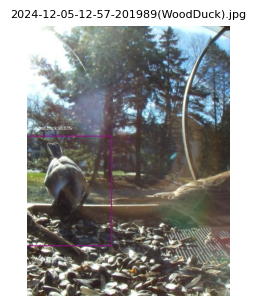

In [8]:
# sample of potential false positives 2024, one per row
# for fp_name in name_counts_2024[name_counts_2024 <= 150].keys(): 
#     false_positives_2024 = df_2024[df_2024['Name'] == fp_name]
#     img_filename = false_positives_2024.iloc[0]['Image Name']
#     img = web_storage.get_img_file(img_filename)

#     # Display the image using matplotlib
#     fig, ax = plt.subplots(figsize=(12, 10))  
#     ax.imshow(img)
#     ax.axis('off')  # Hide axes
#     ax.set_title(img_filename)  
#     plt.show()

# print four images per year from the list of potential false positives, use the first occurrence of each image for that species as an example
images_per_row = 4
fp_names = list(name_counts_2024[name_counts_2024 <= 150].keys()) 
num_rows = np.ceil(len(fp_names) / images_per_row).astype(int)
for ii in range(num_rows):
    fig, axes = plt.subplots(1, images_per_row, figsize=(12, 3))  
    
    for jj in range(images_per_row):
        fp_index = ii * images_per_row + jj
        if fp_index < len(fp_names):
            fp_name = fp_names[fp_index]
            false_positives_2024 = df_2024[df_2024['Name'] == fp_name]
            img_filename = false_positives_2024.iloc[0]['Image Name']
            img = web_storage.get_img_file(img_filename)
            axes[jj].imshow(img)
            axes[jj].axis('off')
            axes[jj].set_title(img_filename, fontsize=8)
        else:
            fig.delaxes(axes[jj]) #Delete unused axes to avoid blank space

    plt.tight_layout(pad=0.5)
    plt.show()

### 2025 False Positive Analysis
This image below is actually a tree sparrow!  They don't visit feeders very often so I've always thought of this as a misclassification.  The white tips on the bottom of the wing are the key difference in the males.  House Sparrows have black on the wing tips.  I had to stare at this for quite some time to discern the differences

https://www.allaboutbirds.org/guide/American_Tree_Sparrow/overview  
https://www.allaboutbirds.org/guide/House_Sparrow/photo-gallery/305880301  

Limiting list to 2025 only....

Starting date: 2025-01-01 08:35:05
Ending date: 2025-01-27 14:47:02
Number of Images: 	6221

Possible False Positives: 
Name
White-throated Sparrow    1
Name: count, dtype: int64

Remaining Species: 
Name
House Finch               2988
House Sparrow             2198
Northern Cardinal          445
Mourning Dove              246
Dark-eyed Junco            161
Black-capped Chickadee     128
American Goldfinch          34
American Tree Sparrow       12
Purple Finch                 8
Name: count, dtype: int64


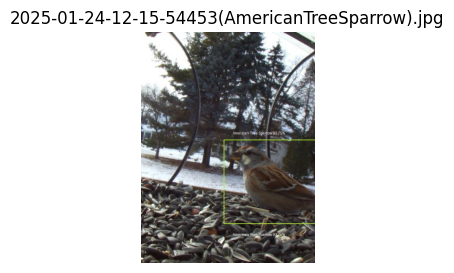

In [9]:
# profile 2025
df_2025 = filter_by_year(df_raw=df_raw, year=2025) 
name_counts_2025 = df_2025['Name'].value_counts()    
print(f'Possible False Positives: \n{name_counts_2025[name_counts_2025 <= 5]}')
print('')
print(f'Remaining Species: \n{name_counts_2025[name_counts_2025 > 5]}')

false_positives_2025 = df_2025[df_2025['Name'] == 'American Tree Sparrow']
# print(false_positives_2025)

# sample of potential false positives 2025
img_filename = false_positives_2025.iloc[0]['Image Name']
web_storage = gcs.Storage(bucket_name='archive_jpg_from_birdclassifier')
img = web_storage.get_img_file(img_filename)

fig, ax = plt.subplots(figsize=(12, 3))  
ax.imshow(img)
ax.axis('off')  
ax.set_title(img_filename)  
plt.show()


### Deeper Analysis of Feeder Data 
When we look at the distrubtion of our true positive and false positives we see a realtively similar shape in the historgrams by month, but there is a noticable shift in the shape of the by hour histograms. The true positive historgram tails off as it gets later in the day while the false positive histogram by hours shows a new peak at 6pm (18:00 hours).  
  
We can get a better sense of the size of the false positives by calculating and ploting the percentage of the total by month and hour.  This shows a clear trend of increasing false positives at 6pm across all months and during the month of august at 1pm.  I happen to know from experience that after noon during the summer there is about an hour where the images get over exposed.  The issue is visible in the false positive image samples above in the second to last image: 2024-06-05-11-38 ... (Baltimore Oriele).jpg.  This particular image was taken on June 5th at 11:38 AM. 

To correct this I added some code to check for a red color imbalance off the images and to have those rejected.  It looks like that code was added in early Aug of 2024.  The addition of this code certainly reduced the number of poor images, but statistically it looks like there are additional opportunities to prune poor imagery.  

Further analysis plotting the % of focal, contrast, and exposure quality by hour, month, and by hour for August shows that exposure seems to be the largest issue and that isn't just early or late, but at mid-day in the summer as well.  

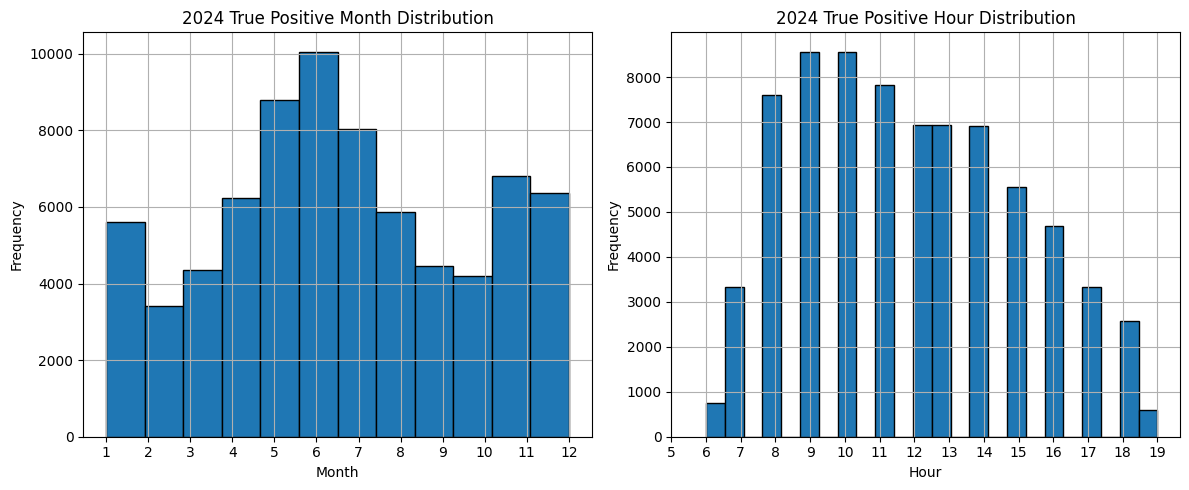

In [10]:
# plot the histograms for 2024 name counts exlcuing false positives <= 150
filtered_data = name_counts_2024[name_counts_2024 > 150]
# plt.bar(filtered_data.index, filtered_data.values) 
# plt.xticks(rotation='vertical')
# plt.xlabel("Species")
# plt.ylabel("Count")
# plt.title("2024 Species Histogram: Feeder")
# plt.tight_layout()
# plt.show()

# distribution of true positives 2024, by month and hour of day
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Plot the histogram for 'month'
tp_2024 = df_2024[df_2024['Name'].isin(list(name_counts_2024[name_counts_2024 > 150].keys()))]
tp_2024['Month'].hist(ax=axes[0], bins=12, edgecolor='black') 
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Frequency')
axes[0].set_title('2024 True Positive Month Distribution')
axes[0].set_xticks(range(1, 13))  

# Plot the histogram for 'hour'
tp_2024['Hour'].hist(ax=axes[1], bins=24, edgecolor='black') 
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Frequency')
axes[1].set_title('2024 True Positive Hour Distribution')
axes[1].set_xticks(range(5, 20))  

plt.tight_layout()  
plt.show()



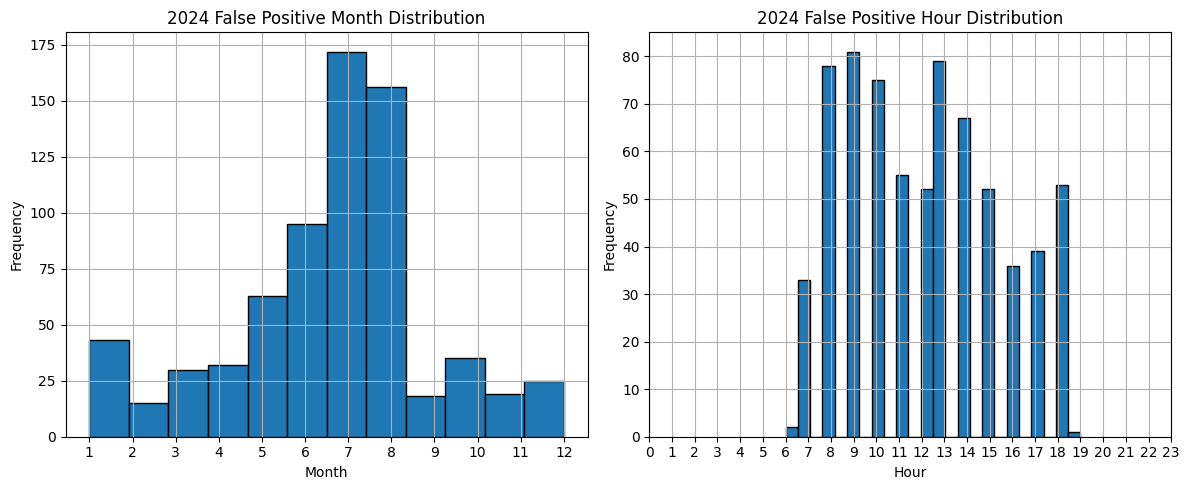

In [11]:
# distribution of false positives 2024, by month and hour of day
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Plot the histogram for 'month'
fp_2024 = df_2024[df_2024['Name'].isin(list(name_counts_2024[name_counts_2024 <= 150].keys()))]
fp_2024['Month'].hist(ax=axes[0], bins=12, edgecolor='black') 
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Frequency')
axes[0].set_title('2024 False Positive Month Distribution')
axes[0].set_xticks(range(1, 13))  

# Plot the histogram for 'hour'
fp_2024['Hour'].hist(ax=axes[1], bins=24, edgecolor='black') 
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Frequency')
axes[1].set_title('2024 False Positive Hour Distribution')
axes[1].set_xticks(range(0, 24))  

plt.tight_layout()  
plt.show()


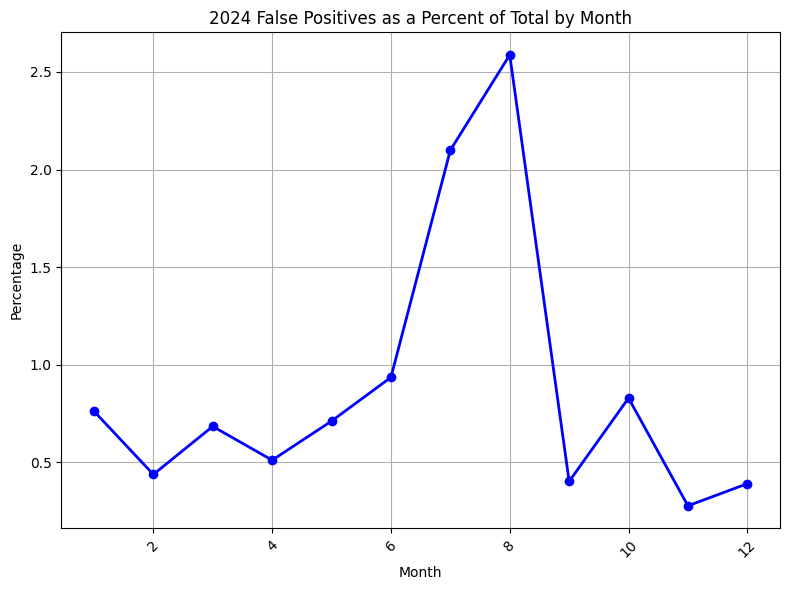

In [13]:
# false positives as a precentage of total observed by month
fp_counts = fp_2024['Month'].value_counts().sort_index()  # Sort for consistent plotting order
t_counts = df_2024['Month'].value_counts().sort_index()
ratio = fp_counts / t_counts * 100

plt.figure(figsize=(8, 6))  
plt.plot(ratio.index, ratio.values, marker='o', color='blue', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('2024 False Positives as a Percent of Total by Month')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

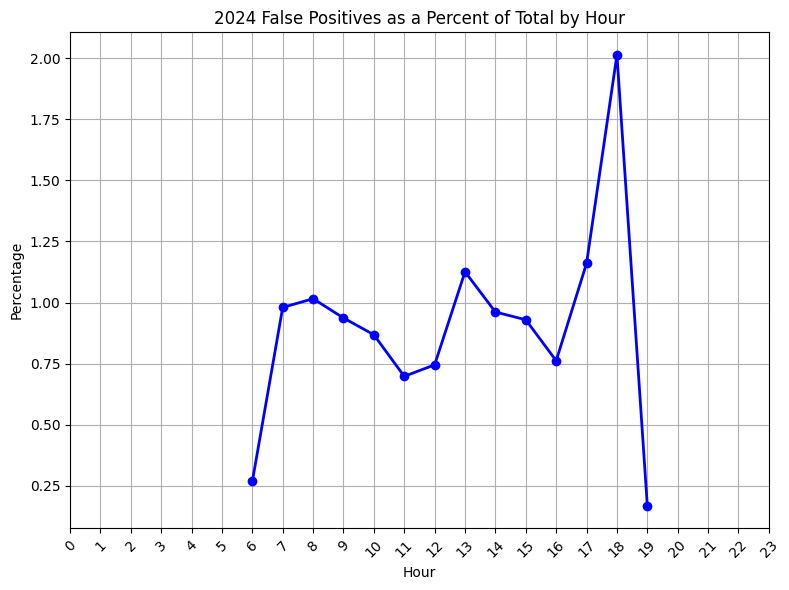

In [14]:
# false positives as a precentage of total observed by hour
fp_counts = fp_2024['Hour'].value_counts().sort_index()  # Sort for consistent plotting order
t_counts = df_2024['Hour'].value_counts().sort_index()
ratio = fp_counts / t_counts * 100

plt.figure(figsize=(8, 6))  
plt.plot(ratio.index, ratio.values, marker='o', color='blue', linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.title('2024 False Positives as a Percent of Total by Hour')
plt.grid(True)
plt.xticks(range(0, 24))  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

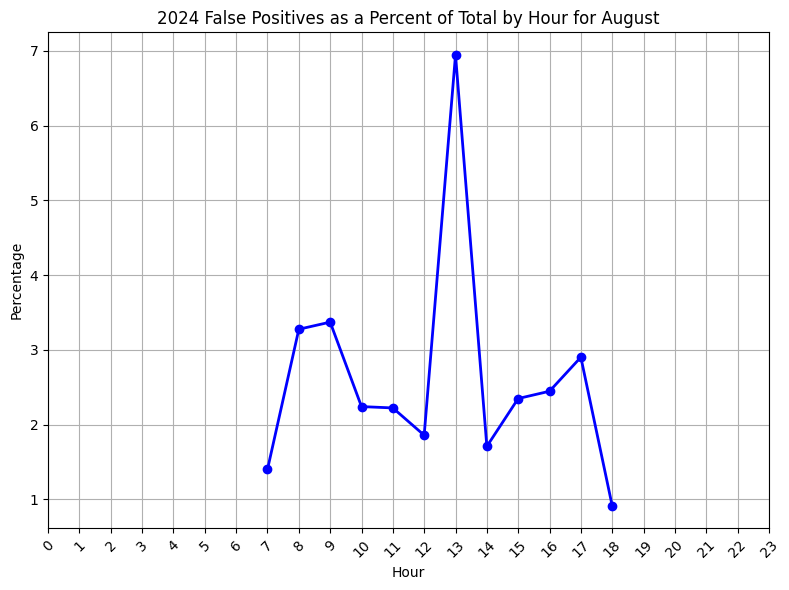

In [15]:
# false positives as a precentage of total observed by hour for august
# Filter for August (Month 8)
df_2024_aug = df_2024[df_2024['Month'] == 8]
fp_2024_aug = fp_2024[fp_2024['Month'] == 8]

fp_counts = fp_2024_aug['Hour'].value_counts().sort_index()  # Sort for consistent plotting order
t_counts = df_2024_aug['Hour'].value_counts().sort_index()
ratio = fp_counts / t_counts * 100

plt.figure(figsize=(8, 6))  
plt.plot(ratio.index, ratio.values, marker='o', color='blue', linewidth=2)
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.title('2024 False Positives as a Percent of Total by Hour for August')
plt.grid(True)
plt.xticks(range(0, 24))  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Feeder Image Quality
Pertuz, S., Puig, D., & Gracia, M. (2013) compared a number of different techniques to measure focal quality.  They concluded that the Laplacain operator was the best overall measure.  I have an implementation of that from OpenCv in this notebook.  After some experimentation it would seem that a variance of anything under 100 lack edges and is therefore low quality.  

The notebook also implements measures for avg exposure.  The images are converted to gray scale and than to a 2 dimensional numpy array.  The values are from 0 (unexposed) to 255 (full exposure) so, np.mean can be used to calculate the average exposure.  Similarly the contrast can be measured using the standard deviation function on the same numpy array.  The quality determinations are not exact, but the assumptions are listed here:  
- Focal quality >= 100  
- Contrast quality between 49 and 101 
- Exposure quality between 99 and 151 

In [19]:
# sample df_2024 for analysis on the pictures themselves
# blur or focus quality: anything under 100 is low quality
# contrast: good is between 50 and 100, < 50 lacks detail, >100 losses detail in light and dark areas
# avg exposure: < 100 is too dark > 150 is washed out
start_time = time.time()
sample_size = 1000
df_2024_sample = df_2024.sample(n=sample_size, random_state=1)
(df_2024_sample['Hour'].value_counts().sort_index())

df_2024_sample['Image'] = df_2024_sample['Image Name'].apply(web_storage.get_img_file)
df_2024_sample['Focal'] = df_2024_sample['Image'].apply(focal_quality)
df_2024_sample['Contrast'] = df_2024_sample['Image'].apply(image_proc.contrast_quality)
df_2024_sample['Exposure'] = df_2024_sample['Image'].apply(image_proc.avg_exposure)
                            
df_2024_sample['Focal Quality'] = (df_2024_sample['Focal'] > 100)
df_2024_sample['Contrast Quality'] = (df_2024_sample['Contrast'] > 50) & (df_2024_sample['Contrast'] < 100)
df_2024_sample['Exposure Quality'] = (df_2024_sample['Exposure'] > 100) & (df_2024_sample['Exposure'] < 150)
df_2024_sample['Any Quality Issue'] = ~(df_2024_sample['Focal Quality'] & df_2024_sample['Contrast Quality'] & df_2024_sample['Exposure Quality'])  
print(f'Elapsed time: {time.time() - start_time:.4f} seconds')
print(f'Time per 10 images: {(time.time()-start_time)/(sample_size/10):.4f}')

Elapsed time: 103.1369 seconds


In [25]:
# Calculate percentages
total_images = df_2024_sample.shape[0]
focal_issue_percentage = (df_2024_sample['Focal Quality'].sum() / total_images) * 100
contrast_issue_percentage = (df_2024_sample['Contrast Quality'].sum() / total_images) * 100
exposure_issue_percentage = (df_2024_sample['Exposure Quality'].sum() / total_images) * 100
any_issue_percentage = (df_2024_sample['Any Quality Issue'].sum() / total_images) * 100
print(f'Number of images: {df_2024_sample.shape[0]}')
print(f'Percentage of images with focal quality problem {100 - focal_issue_percentage:.2f}%')
print(f'Percentage of images with contrast quality problem {100 - contrast_issue_percentage:.2f}%')
print(f'Percentage of images with exposure quality problem {100 - exposure_issue_percentage:.2f}%')

Number of images: 1000
Percentage of images with focal quality problem 0.00
Percentage of images with contrast quality problem 2.20
Percentage of images with exposure quality problem 31.10


In [27]:
# Calculate percentages by species
for species in df_2024_sample['Name'].unique():  # Iterate through unique species
    df_species = df_2024_sample[df_2024_sample['Name'] == species]  # Filter for current species
    total_images_species = len(df_species)

    if total_images_species > 0:  # Avoid division by zero if a species has no samples
        focal_issue_percentage = (df_species['Focal Quality'].sum() / total_images_species) * 100
        contrast_issue_percentage = (df_species['Contrast Quality'].sum() / total_images_species) * 100
        exposure_issue_percentage = (df_species['Exposure Quality'].sum() / total_images_species) * 100
        any_issue_percentage = (df_species['Any Quality Issue'].sum() / total_images_species) * 100

        print(f'Species: {species}')
        print(f'
        print(f'  Percentage of images with Focal Quality Issue: {focal_issue_percentage:.2f}%')
        print(f'  Percentage of images with Contrast Quality Issue: {contrast_issue_percentage:.2f}%')
        print(f'  Percentage of images with Exposure Quality Issue: {exposure_issue_percentage:.2f}%')
        print(f'  Percentage of images with Any Quality Issue: {any_issue_percentage:.2f}%')
    else:
        print(f'No samples found for species: {species}')
    print('')  

Species: Mourning Dove
  Percentage of images with Focal Quality Issue: 100.00%
  Percentage of images with Contrast Quality Issue: 98.55%
  Percentage of images with Exposure Quality Issue: 70.29%
  Percentage of images with Any Quality Issue: 29.71%

Species: House Sparrow
  Percentage of images with Focal Quality Issue: 100.00%
  Percentage of images with Contrast Quality Issue: 97.04%
  Percentage of images with Exposure Quality Issue: 62.07%
  Percentage of images with Any Quality Issue: 37.93%

Species: House Finch
  Percentage of images with Focal Quality Issue: 100.00%
  Percentage of images with Contrast Quality Issue: 98.30%
  Percentage of images with Exposure Quality Issue: 72.51%
  Percentage of images with Any Quality Issue: 27.49%

Species: Brown-headed Cowbird
  Percentage of images with Focal Quality Issue: 100.00%
  Percentage of images with Contrast Quality Issue: 88.24%
  Percentage of images with Exposure Quality Issue: 64.71%
  Percentage of images with Any Qualit

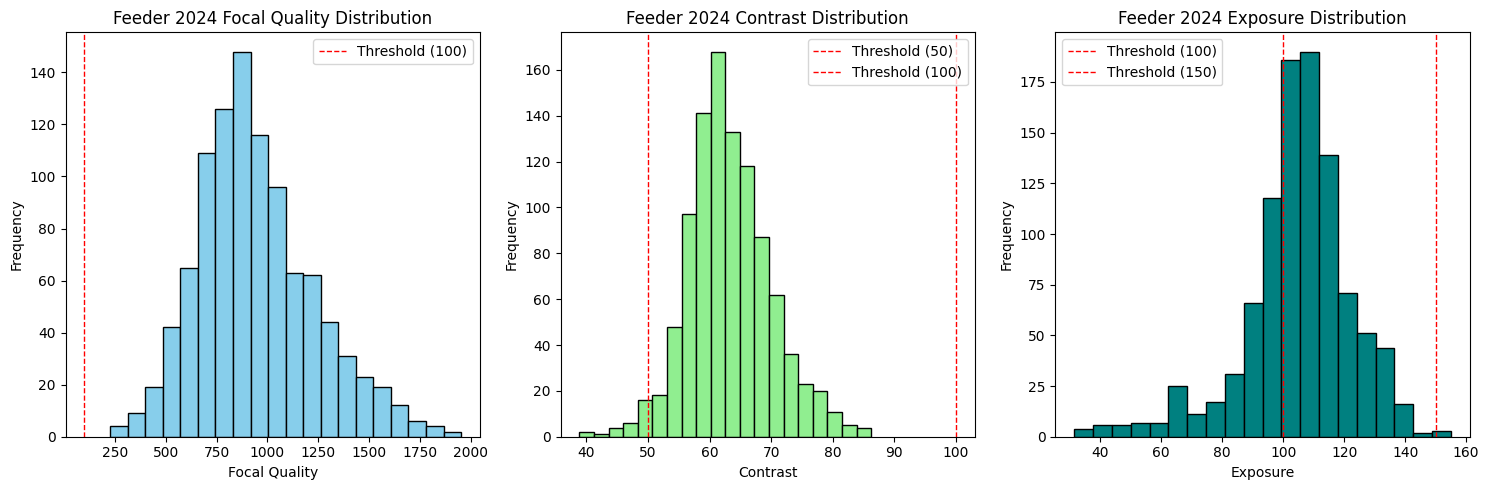

In [24]:
# plot histograms for focal, contrast, and exposure
plt.figure(figsize=(15, 5)) 
plt.subplot(1, 3, 1)  # 1 row, 3 columns
plt.hist(df_2024_sample['Focal'], bins=20, color='skyblue', edgecolor='black')
plt.title('Feeder 2024 Focal Quality Distribution')
plt.xlabel('Focal Quality')
plt.ylabel('Frequency')
plt.axvline(100, color='red', linestyle='dashed', linewidth=1, label='Threshold (100)') # Threshold line
plt.legend()


plt.subplot(1, 3, 2)  # 1 row, 3 columns, second plot
plt.hist(df_2024_sample['Contrast'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Feeder 2024 Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.axvline(50, color='red', linestyle='dashed', linewidth=1, label='Threshold (50)')
plt.axvline(100, color='red', linestyle='dashed', linewidth=1, label='Threshold (100)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, third plot
plt.hist(df_2024_sample['Exposure'], bins=20, color='teal', edgecolor='black')
plt.title('Feeder 2024 Exposure Distribution')
plt.xlabel('Exposure')
plt.ylabel('Frequency')
plt.axvline(100, color='red', linestyle='dashed', linewidth=1, label='Threshold (100)')
plt.axvline(150, color='red', linestyle='dashed', linewidth=1, label='Threshold (150)')
plt.legend()

plt.tight_layout()  
plt.show()


In [17]:
# percentage of images that are quality across these three categories by hour
print('Percent of Images that are "Quality: True or False" by hour')
quality_by_hour_detailed = df_2024_sample.groupby('Hour')[['Focal Quality', 'Contrast Quality', 'Exposure Quality']].mean() * 100
print(quality_by_hour_detailed)

Percent of Images that are "Quality: True or False" by hour
      Focal Quality  Contrast Quality  Exposure Quality
Hour                                                   
6             100.0        100.000000         50.000000
7             100.0        100.000000         82.926829
8             100.0         92.857143         58.035714
9             100.0         98.260870         70.434783
10            100.0         99.218750         85.937500
11            100.0        100.000000         75.892857
12            100.0         98.701299         77.922078
13            100.0         98.989899         76.767677
14            100.0         98.913043         58.695652
15            100.0         94.366197         63.380282
16            100.0        100.000000         66.666667
17            100.0        100.000000         57.142857
18            100.0         92.682927         36.585366
19            100.0         90.000000         10.000000


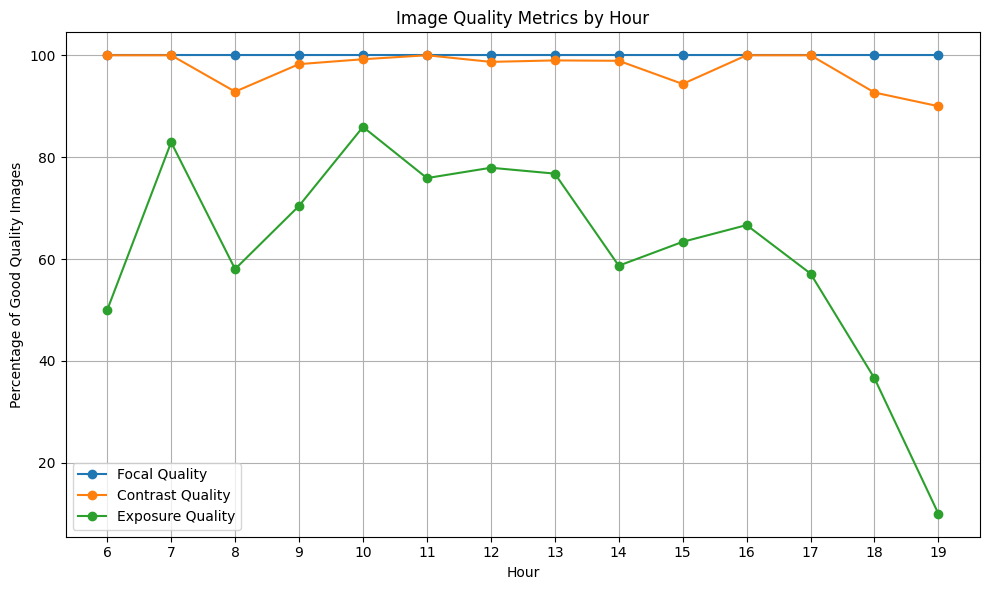

In [18]:
# image quality by hour
plt.figure(figsize=(10, 6))  
hours = quality_by_hour_detailed.index  # hours from the index
plt.plot(hours, quality_by_hour_detailed['Focal Quality'], label='Focal Quality', marker='o')
plt.plot(hours, quality_by_hour_detailed['Contrast Quality'], label='Contrast Quality', marker='o')
plt.plot(hours, quality_by_hour_detailed['Exposure Quality'], label='Exposure Quality', marker='o')
plt.xlabel('Hour')
plt.ylabel('Percentage of Good Quality Images')
plt.title('Image Quality Metrics by Hour')
plt.legend()
plt.xticks(hours) 
plt.grid(True)  
plt.tight_layout()
plt.show()



In [19]:
# percentage with any quality issue by hour 
# quality_by_hour = df_2024_sample.groupby('Hour')['Any Quality Issue'].mean() * 100
# print(quality_by_hour)

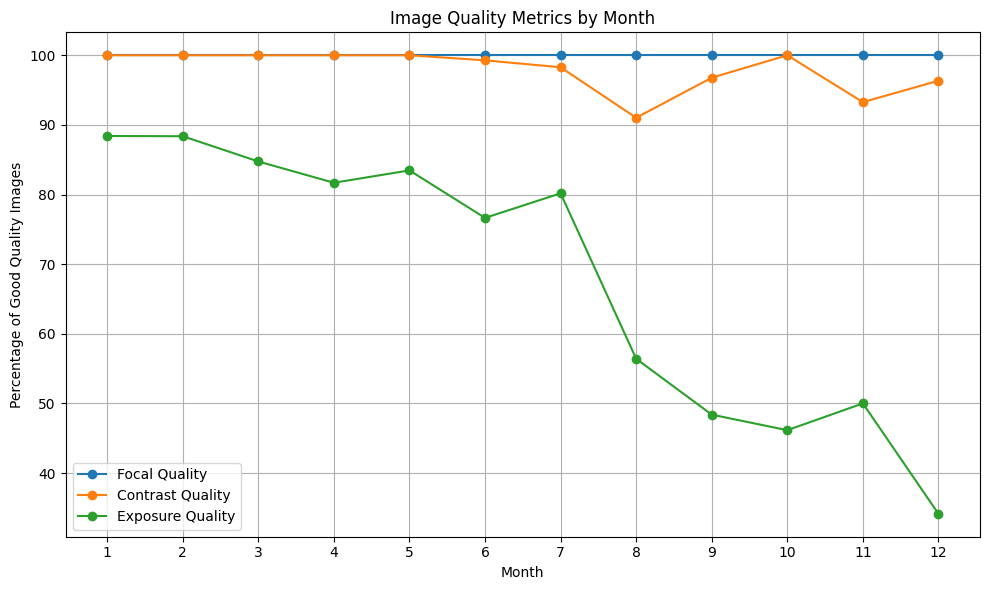

In [20]:
# image quality by month
quality_by_month_detailed = df_2024_sample.groupby('Month')[['Focal Quality', 'Contrast Quality', 'Exposure Quality']].mean() * 100
plt.figure(figsize=(10, 6))
months = quality_by_month_detailed.index

plt.plot(months, quality_by_month_detailed['Focal Quality'], label='Focal Quality', marker='o')
plt.plot(months, quality_by_month_detailed['Contrast Quality'], label='Contrast Quality', marker='o')
plt.plot(months, quality_by_month_detailed['Exposure Quality'], label='Exposure Quality', marker='o')
plt.xlabel('Month')
plt.ylabel('Percentage of Good Quality Images')
plt.title('Image Quality Metrics by Month')
plt.legend()
plt.xticks(months) 
plt.grid(True)
plt.tight_layout()
plt.show()

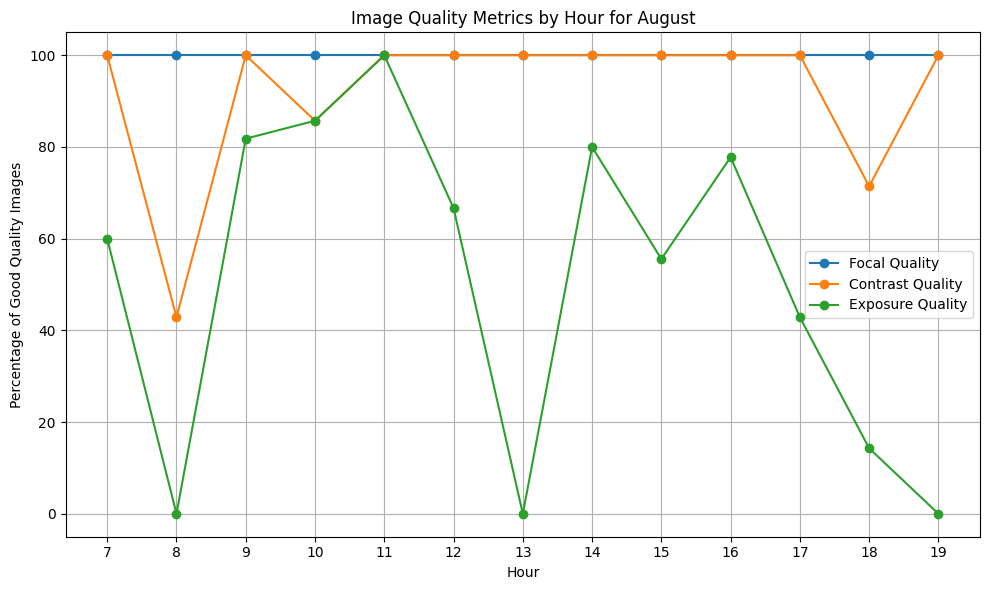

In [26]:
# image quality by hour for August
df_2024_sample_aug = df_2024_sample[df_2024_sample['Month'] == 8]
quality_by_hour_detailed_aug = df_2024_sample_aug.groupby('Hour')[['Focal Quality', 'Contrast Quality', 'Exposure Quality']].mean() * 100

plt.figure(figsize=(10, 6))  
hours = quality_by_hour_detailed_aug.index  # hours from the index
plt.plot(hours, quality_by_hour_detailed_aug['Focal Quality'], label='Focal Quality', marker='o')
plt.plot(hours, quality_by_hour_detailed_aug['Contrast Quality'], label='Contrast Quality', marker='o')
plt.plot(hours, quality_by_hour_detailed_aug['Exposure Quality'], label='Exposure Quality', marker='o')
plt.xlabel('Hour')
plt.ylabel('Percentage of Good Quality Images')
plt.title('Image Quality Metrics by Hour for August')
plt.legend()
plt.xticks(hours) 
plt.grid(True)  
plt.tight_layout()
plt.show()



In [22]:
# contrast and exposure are not strongly correlated at .46, but there is a correlation
correlation = quality_by_hour_detailed_aug['Contrast Quality'].corr(quality_by_hour_detailed_aug['Exposure Quality'])
print(f'Correlation between Contrast and Exposure Quality for August: {correlation}')

Correlation between Contrast and Exposure Quality for August: 0.46871321287933476


In [46]:
# what if we drop poor exposure quality in all months?  
df_filtered = df_2024_sample[df_2024_sample['Exposure Quality'] != False] 
total_remaining = len(df_filtered)
print(f'Images remaining from total sample without Exposure issues {total_remaining}')

contrast_false_remaining = len(df_filtered[df_filtered['Contrast Quality'] == False])
print(f'Images remaining from total sample without Exposure issues and with Contrast issues {contrast_false_remaining}')

percentage = (contrast_false_remaining / total_remaining) * 100
print(f'Percentage of remaining rows (August) with Contrast Quality False: {percentage:.2f}%')

common_image_names = set(df_2024_sample['Image Name']).intersection(set(fp_2024['Image Name']))
print(f'Dropping bad exposure leaves just {len(common_image_names)} out of a possible {fp_2024.shape[0]} bad images in 2024 Sample')


Images remaining from total sample without Exposure issues 689
Images remaining from total sample without Exposure issues and with Contrast issues 0
Percentage of remaining rows (August) with Contrast Quality False: 0.00%
Dropping bad exposure leaves just 13 out of a possible 703 bad images in 2024 Sample


In [47]:
# what if we remove all rows with an exposure problem in August? Do we have any contrast issue remaining?  
df_2024_sample_aug = df_2024_sample[df_2024_sample['Month'] == 8]
df_filtered = df_2024_sample_aug[df_2024_sample_aug['Exposure Quality'] != False] 
total_remaining = len(df_filtered)
print(f'Images remaining from August sample without Exposure issues {total_remaining}')
# print(df_filtered.head(5))
contrast_false_remaining = len(df_filtered[df_filtered['Contrast Quality'] == False])
print(f'Images remaining from total sample without Exposure issues and with Contrast issues {contrast_false_remaining}')
percentage = (contrast_false_remaining / total_remaining) * 100
print(f'Percentage of remaining rows (August) with Contrast Quality False: {percentage:.2f}%')

common_image_names = set(df_2024_sample_aug['Image Name']).intersection(set(fp_2024_aug['Image Name']))
print(f'Dropping bad exposure leaves just {len(common_image_names)} out of a possible {fp_2024_aug.shape[0]} bad images in August')



Images remaining from August sample without Exposure issues 44
Images remaining from total sample without Exposure issues and with Contrast issues 0
Percentage of remaining rows (August) with Contrast Quality False: 0.00%
Dropping bad exposure leaves just 2 out of a possible 156 bad images in August


### Conclusions
Elminating low quality exposure elminates the low quality contrast issues.  
Focal quality is a very minor problem at about 1% so don't bother

### Analysis of 2025 Images 
2025 is a partial year with limited utility.  This analysis was used as a part of the initial data review and is included here for completenedd. 

In [24]:
# profile 2025
df_2025 = filter_by_year(df_raw=df_raw, year=2025) 
name_counts_2025 = df_2025['Name'].value_counts()    
print(f'Possible False Positives: \n{name_counts_2025[name_counts_2025 <= 5]}')
print('')
print(f'Remaining Species: \n{name_counts_2025[name_counts_2025 > 5]}')

Limiting list to 2025 only....

Starting date: 2025-01-01 08:35:05
Ending date: 2025-01-27 14:47:02
Number of Images: 	6221

Possible False Positives: 
Name
White-throated Sparrow    1
Name: count, dtype: int64

Remaining Species: 
Name
House Finch               2988
House Sparrow             2198
Northern Cardinal          445
Mourning Dove              246
Dark-eyed Junco            161
Black-capped Chickadee     128
American Goldfinch          34
American Tree Sparrow       12
Purple Finch                 8
Name: count, dtype: int64


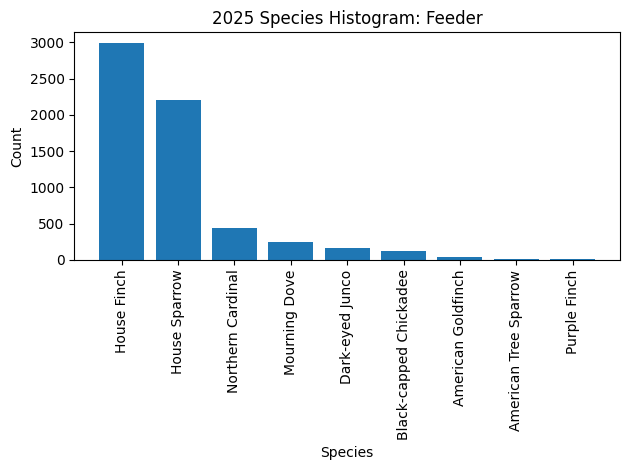

In [25]:
# plot the histograms for 2025 name counts excluding false positives below a count of 5
filtered_data = name_counts_2025[name_counts_2025 > 5]
plt.bar(filtered_data.index, filtered_data.values) 
plt.xticks(rotation='vertical')
plt.xlabel("Species")
plt.ylabel("Count")
plt.title("2025 Species Histogram: Feeder")
plt.tight_layout()
plt.show()
